<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W3/ungraded_labs/C4_W3_Lab_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.8.0


In [4]:
%matplotlib inline

In [5]:
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [6]:
df = pd.read_csv("../../../../../../../../data/APPL.csv", low_memory=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5602 entries, 0 to 5601
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  5602 non-null   object 
 1   1. open               5602 non-null   float64
 2   2. high               5602 non-null   float64
 3   3. low                5602 non-null   float64
 4   4. close              5602 non-null   float64
 5   5. adjusted close     5602 non-null   float64
 6   6. volume             5602 non-null   float64
 7   7. dividend amount    5602 non-null   float64
 8   8. split coefficient  5602 non-null   float64
dtypes: float64(8), object(1)
memory usage: 394.0+ KB


In [8]:
df.sort_values(by=["date"], inplace=True)

In [9]:
df.head()

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
5601,1999-11-01,80.00,80.69,77.37,77.62,0.594112,2487300.0,0.0,1.0
5600,1999-11-02,78.00,81.69,77.31,80.25,0.614243,3564600.0,0.0,1.0
5599,1999-11-03,81.62,83.25,81.00,81.50,0.623810,2932700.0,0.0,1.0
5598,1999-11-04,82.06,85.37,80.62,83.62,0.640037,3384700.0,0.0,1.0
5597,1999-11-05,84.62,88.37,84.00,88.31,0.675935,3721500.0,0.0,1.0


In [10]:
int(len(df) * .8)

4481

In [11]:
time = np.arange(len(df), dtype="float32")
time

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.599e+03, 5.600e+03,
       5.601e+03], dtype=float32)

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# def trend(time, slope=0):
#     return slope * time

# def seasonal_pattern(season_time):
#     """Just an arbitrary pattern, you can change it if you wish"""
#     return np.where(season_time < 0.4,
#                     np.cos(season_time * 2 * np.pi),
#                     1 / np.exp(3 * season_time))

# def seasonality(time, period, amplitude=1, phase=0):
#     """Repeats the same pattern at each period"""
#     season_time = ((time + phase) % period) / period
#     return amplitude * seasonal_pattern(season_time)

# def noise(time, noise_level=1, seed=None):
#     rnd = np.random.RandomState(seed)
#     return rnd.randn(len(time)) * noise_level

# time = np.arange(4 * 365 + 1, dtype="float32")
# baseline = 10
# series = trend(time, 0.1)  
# baseline = 10
# amplitude = 40
# slope = 0.05
# noise_level = 5

# # Create the series
# series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# # Update with noise
# series += noise(time, noise_level, seed=42)


# df.set_index("date", inplace=True)
# df = df[["5. adjusted close"]]

# df.sort_values(by=["date"], ascending=True, inplace=True)

df.reset_index(inplace=True)

series = df["5. adjusted close"].to_numpy()

time = np.arange(len(df), dtype="float32")


split_time = int(len(series) * .8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = split_time

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=30, callbacks=[lr_schedule])

Epoch 1/30
140/140 [==============================] - 12s 31ms/step - loss: 3.0287 - mae: 3.5110 - lr: 1.0000e-08
Epoch 2/30
140/140 [==============================] - 5s 27ms/step - loss: 2.8542 - mae: 3.3345 - lr: 1.1220e-08
Epoch 3/30
140/140 [==============================] - 5s 30ms/step - loss: 2.6828 - mae: 3.1611 - lr: 1.2589e-08
Epoch 4/30
140/140 [==============================] - 5s 30ms/step - loss: 2.5111 - mae: 2.9873 - lr: 1.4125e-08
Epoch 5/30
140/140 [==============================] - 5s 30ms/step - loss: 2.3421 - mae: 2.8115 - lr: 1.5849e-08
Epoch 6/30
140/140 [==============================] - 5s 29ms/step - loss: 2.1801 - mae: 2.6325 - lr: 1.7783e-08
Epoch 7/30
140/140 [==============================] - 5s 29ms/step - loss: 2.0307 - mae: 2.4585 - lr: 1.9953e-08
Epoch 8/30
140/140 [==============================] - 9s 57ms/step - loss: 1.8964 - mae: 2.3027 - lr: 2.2387e-08
Epoch 9/30
140/140 [==============================] - 6s 36ms/step - loss: 1.7786 - mae: 2.1690

(1e-08, 1e-06, 0.0, 5.0)

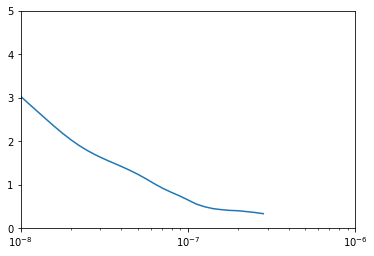

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-6, 0, 5])

In [133]:
# This code block will take some time to run.
# But it will run in the background, without displaying/printing 
# the information about the number of epochs.


# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

# tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])


# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=["mae"])
# history = model.fit(dataset,epochs=50,verbose=0)

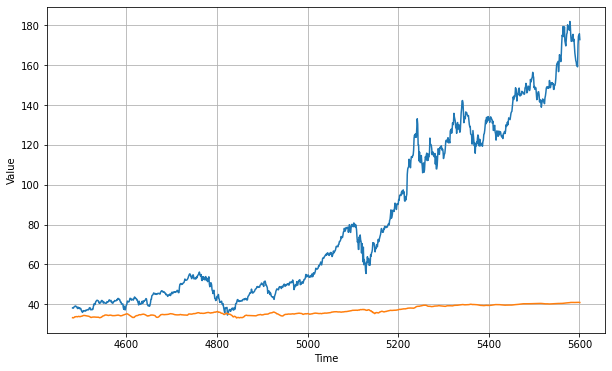

In [17]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

44.575188

<Figure size 432x288 with 0 Axes>

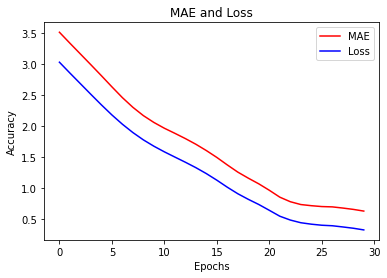

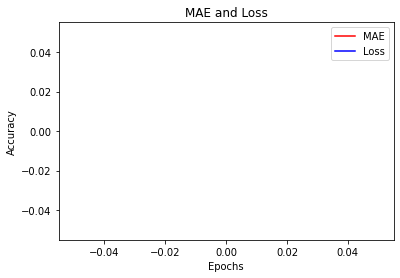

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [20]:
# This code block will take some time to run.
# But it will run in the background, without displaying/printing 
# the information about the number of epochs.

# tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1)
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])


# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
# model.fit(dataset,epochs=10, verbose=0)

In [ ]:
# tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])


# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
# model.fit(dataset,epochs=100)